<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#LG-beam-$LG_{p,m}(r,-\phi)$" data-toc-modified-id="LG-beam-$LG_{p,m}(r,-\phi)$-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>LG beam $LG_{p,m}(r, \phi)$</a></span></li><li><span><a href="#VVB-on-a-Bloch-Sphere" data-toc-modified-id="VVB-on-a-Bloch-Sphere-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>VVB on a Bloch Sphere</a></span><ul class="toc-item"><li><span><a href="#$|\psi\rangle=\cos{\frac{\alpha}{2}}|R,m_1\rangle+-\sin{\frac{\alpha}{2&#10;}}e^{i-\beta}|L,m_2\rangle$" data-toc-modified-id="$|\psi\rangle=\cos{\frac{\alpha}{2}}|R,m_1\rangle+-\sin{\frac{\alpha}{2
}}e^{i-\beta}|L,m_2\rangle$-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>$|\psi\rangle=\cos{\frac{\alpha}{2}}|R,m_1\rangle+ \sin{\frac{\alpha}{2
}}e^{i \beta}|L,m_2\rangle$</a></span></li></ul></li></ul></div>

In [5]:
import os
import sys
import numpy as np
import pandas as pd
import scipy
import scipy.special
import math
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

if './src' not in sys.path:
    sys.path.append('./src')
import src.vector_vortex_beams as VVB

%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# LG beam $LG_{p,m}(r, \phi)$

In [9]:
# Camera resolution
camera_width = 1024
camera_height = 768

Y, X = np.meshgrid(
    np.linspace(-camera_height / 2, camera_height / 2, num=camera_height + 1),
    np.linspace(-camera_width / 2, camera_width / 2, num=camera_width + 1)
)

Profiles for $p=0$ and $m=-5,-4,...,4,5$.

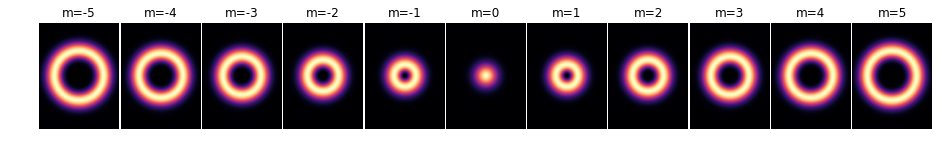

In [93]:
fig, axs = plt.subplots(nrows=1, ncols=11, figsize=(16, 6))
for ax, m in zip(axs, np.arange(-5, 6)):
    amps = VVB.LaguerreGauss(X, Y, p=0, m=m, w0=150)
    ax.axis('off'); ax.set_title('m={}'.format(m))
    VVB.plot_intensity(amps, ax=ax)
fig.subplots_adjust(hspace=0, wspace=.02)

Profiles for $p=1$ and $m=-5,-4,...,4,5$

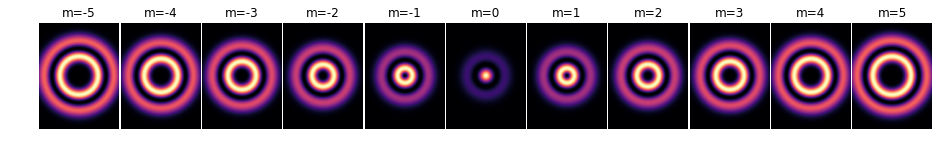

In [92]:
fig, axs = plt.subplots(nrows=1, ncols=11, figsize=(16, 6))
for ax, m in zip(axs, np.arange(-5, 6)):
    amps = VVB.LaguerreGauss(X, Y, p=1, m=m, w0=150)
    ax.axis('off'); ax.set_title('m={}'.format(m))
    VVB.plot_intensity(amps, ax=ax)
fig.subplots_adjust(hspace=0, wspace=.02)

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=9, figsize=(20, 6))
for ax, m in zip(axs, np.arange(-4, 5)):
    amps = VVB.LaguerreGauss(X, Y, p=1, m=0, w0=150) + VVB.LaguerreGauss(X, Y, p=1, m=m, w0=150)
    ax.axis('off'); ax.set_title(r'$| 0\rangle + | {}\rangle$'.format(m))
    VVB.plot_intensity(amps, ax=ax)
fig.subplots_adjust(hspace=0, wspace=.02)

# VVB on a Bloch Sphere 
## $|\psi\rangle=\cos{\frac{\alpha}{2}}|R,m_1\rangle+ \sin{\frac{\alpha}{2
}}e^{i \beta}|L,m_2\rangle$

In [15]:
#projectors for stokes measurements

def rotation_matrix(theta):
    """Compute 2D rotation matrix given an angle in degrees (NOT radians)."""
    return np.array([[np.cos(np.radians(theta)),-np.sin(np.radians(theta))],
                     [np.sin(np.radians(theta)), np.cos(np.radians(theta))]])

def rotated_waveplate_matrix(theta, waveplate_matrix):
    """Compute matrix representing a rotated waveplate.
    
    Angles are to be given in degrees.
    """
    return np.dot(rotation_matrix(theta),
                  np.dot(waveplate_matrix, rotation_matrix(-theta)))

def rotated_HWP_matrix(angle):
    """Compute matrix representing a rotated half-waveplate.
    
    Angles are to be given in degrees.
    """
    HWP = np.array([[1, 0], [0, -1]])
    return rotated_waveplate_matrix(angle, HWP)

def rotated_QWP_matrix(angle):
    """Compute matrix representing a rotated quarter-waveplate.
    
    Angles are to be given in degrees.
    """
    QWP = np.array([[1, 0], [0, 1j]])
    return rotated_waveplate_matrix(angle, QWP)

def polarization_projection_matrix_from_waveplates(alpha_HWP, alpha_QWP):
    """Compute projectors for the polarization using rotated waveplates matrices."""
    return np.dot(rotated_HWP_matrix(alpha_HWP), rotated_QWP_matrix(alpha_QWP))

def polarization_basis_states(which):
    """Return commonly used basis states from a name."""
    if which == 'H':
        return np.array([1, 0])
    elif which == 'V':
        return np.array([0, 1])
    elif which == 'L':
        return [1, -1j] / np.sqrt(2)
    elif which == 'R':
        return [1, 1j] / np.sqrt(2)
    elif which =='D':
        return [1, 1] / np.sqrt(2)
    elif which == 'A':
        return [1, -1] / np.sqrt(2)


# sV_op = np.dot(rotated_HWP_matrix(45), rotated_QWP_matrix(0))
# sH_op = np.dot(rotated_HWP_matrix(0), rotated_QWP_matrix(0))
# sD_op = np.dot(rotated_HWP_matrix(22.5), rotated_QWP_matrix(45))
# sA_op = np.dot(rotated_HWP_matrix(-22.5), rotated_QWP_matrix(45))
# sL_op = np.dot(rotated_HWP_matrix(22.5), rotated_QWP_matrix(0))
# sR_op = np.dot(rotated_HWP_matrix(-22.5), rotated_QWP_matrix(0))

# #polarization states
# L = [1, -1j] / np.sqrt(2)
# R = [1, 1j] / np.sqrt(2)
# D = [1, 1] / np.sqrt(2)
# A = [1, -1] / np.sqrt(2)
# H = np.array([1, 0])
# V = np.array([0, 1])


def pol_state(state1, state2, beta, alpha): 
    return np.array([
        np.cos(np.radians(alpha / 2)) * state1,
        np.exp(1j * np.radians(beta)) * np.sin(np.radians(alpha / 2)) * state2
    ])

def measurement(projector, state):
    return np.dot(projector, np.transpose(state))

def vec_vortex(coeff,x,y,p,m1,m2,w0):
    return np.round(coeff[0],6)*LG(x,y,p,m2,w0)+np.round(coeff[1],6)*LG(x,y,p,m1,w0)

def stokes_para(Iv,Ih):
   
    return Ih-Iv

In [0]:
#VVB generation with LG
w0=150
m1=-5
m2=1
beta=0
alpha=90

v_mes=measurement(sV_op,pol_state(L,R,beta,alpha))[0]
h_mes=measurement(sH_op,pol_state(L,R,beta,alpha))[0]
d_mes=measurement(sD_op,pol_state(L,R,beta,alpha))[0]
a_mes=measurement(sA_op,pol_state(L,R,beta,alpha))[0]
l_mes=measurement(sL_op,pol_state(L,R,beta,alpha))[0]
r_mes=measurement(sR_op,pol_state(L,R,beta,alpha))[0]

v_vortex=vec_vortex(v_mes,X,Y,0,m1,m2,w0)
h_vortex=vec_vortex(h_mes,X,Y,0,m1,m2,w0)
d_vortex=vec_vortex(d_mes,X,Y,0,m1,m2,w0)
a_vortex=vec_vortex(a_mes,X,Y,0,m1,m2,w0)
l_vortex=vec_vortex(l_mes,X,Y,0,m1,m2,w0)
r_vortex=vec_vortex(r_mes,X,Y,0,m1,m2,w0)

Iv=np.abs(np.transpose(v_vortex))**2
Ih=np.abs(np.transpose(h_vortex))**2
Id=np.abs(np.transpose(d_vortex))**2
Ia=np.abs(np.transpose(a_vortex))**2
Il=np.abs(np.transpose(l_vortex))**2
Ir=np.abs(np.transpose(r_vortex))**2


s1=stokes_para(Ih,Iv)
s2=stokes_para(Id,Ia)
s3=stokes_para(Il,Ir)
s_vector=np.dstack((s1,s2,s3))

H


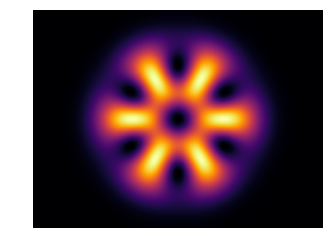

V


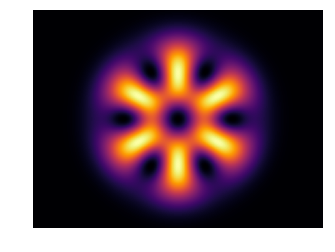

D


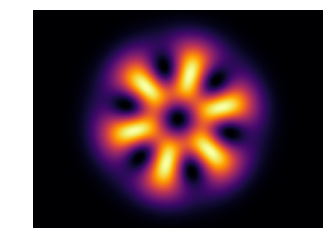

A


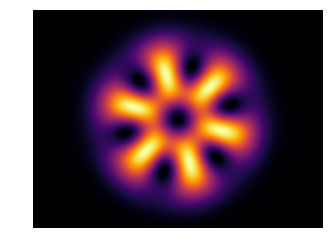

L


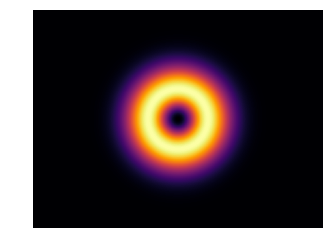

R


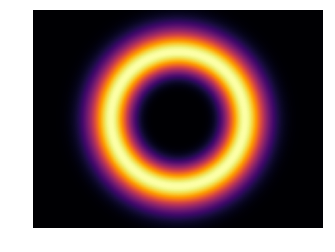

In [0]:
#Checking beam shapes on each polarization basis
beams=np.array([Ih,Iv,Id,Ia,Il,Ir])
basis=['H','V','D','A','L','R']
c=0
for i in beams:
    print(basis[c])
    plt.imshow(i, interpolation='nearest', cmap='inferno')
    plt.axis('off')
    plt.show()
    c=c+1
    

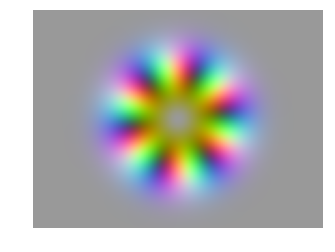

In [0]:
#Polarization patterns econding in RGB colors

stokes=s_vector+np.abs(np.min(s_vector))
#la formula qui sopra mi serve perchè i parametri di Stokes possono essere negativi
#e nella conversione in un colore RGB dà fastidio.
#Quello che faccio è traslare il centro della sfera di Bloch da (0,0,0) a (1,1,1)
#Con le immagini teoriche ho problemi a calcolarmi i parametri di Stokes normalizzati (esplode
#quando deve fare 0/0), infatti la funzione stokes-para non ha il denominatore, e per
#questo traslo di np.abs(np.min(s_vector)) e non di 1 come faccio durante le acquisizioni
#dall'apparato (lì la camera ha un fondo !=0 e non capita mai una divisione 0/0 e 
#riesco ad ottenere i parametri normalizzati). Quesa cosa comunque funziona molto bene, 
#tranne che in prossimità
#dei poli in cui questo codice va un po' adattato ai casi.


rescaled=(256/(np.max(stokes))*(stokes)).astype(np.uint8)

plt.imshow(rescaled,interpolation='nearest')
plt.axis('off')
plt.show()